In [1]:
import numpy as np
import cv2, glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
%matplotlib inline

In [2]:
class Error(Exception):
    pass

In [3]:
#Camera Calibration
def camera_Calibraton(directory, filename, nx, ny, img_size):
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob.glob('/'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #print("name:",fname,"RET:",ret)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist

In [4]:
#Image undistort
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

In [5]:
#Perspective transform
def transform(undist,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M, Minv

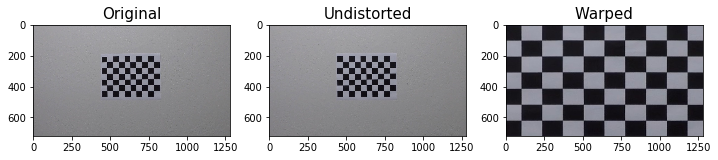

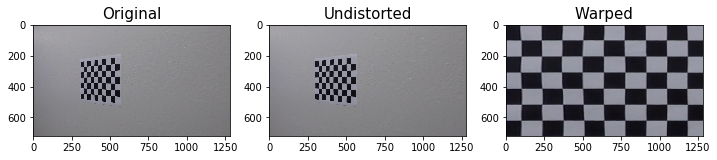

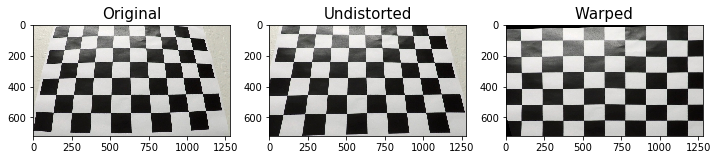

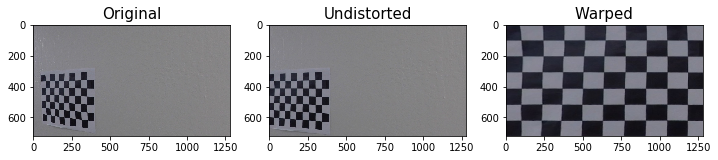

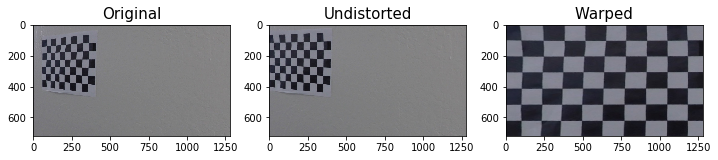

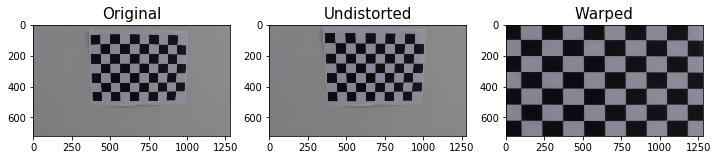

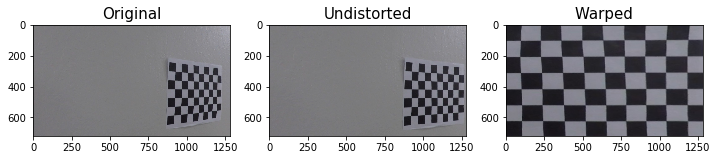

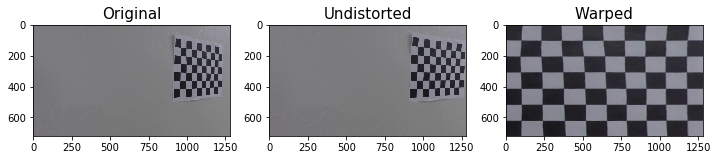

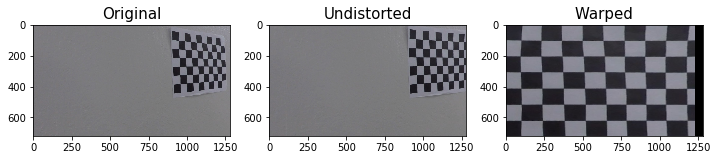

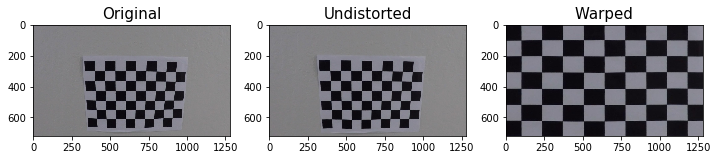

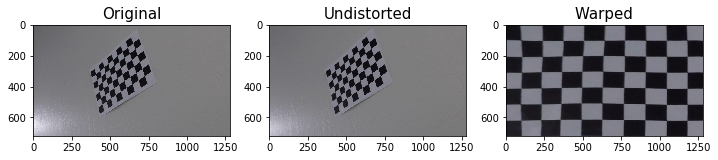

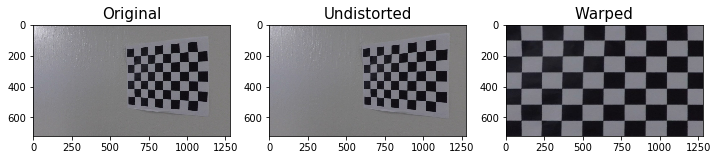

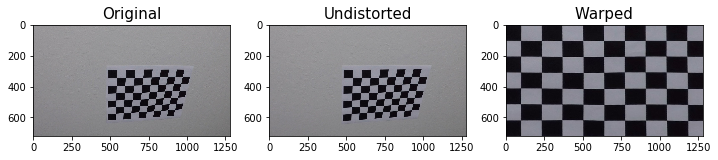

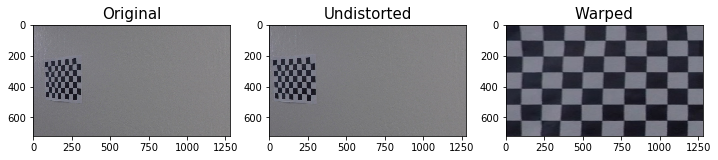

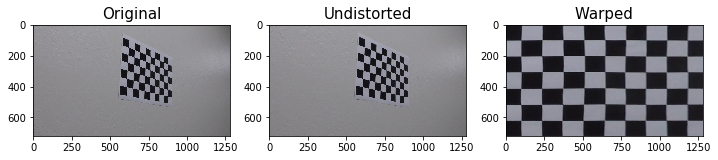

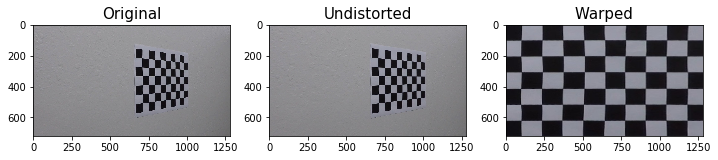

In [6]:
nx = 9
ny = 6
mtx, dist = camera_Calibraton('Users/rickerish_nah/Documents/trials/udacity Q/camera_cal', 'calibration', nx, ny, (720, 1280))

images_calib = glob.glob('/Users/rickerish_nah/Documents/trials/udacity Q/camera_cal/calibration**.jpg')
for i, img in enumerate(images_calib):
    checker_dist = cv2.imread(img)
    checker_dist = cv2.cvtColor(checker_dist, cv2.COLOR_BGR2RGB)
    #Undistort
    checker_undist = undistort(checker_dist, mtx, dist)
    #Warp
    gray = cv2.cvtColor(checker_undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    img_size = (gray.shape[1], gray.shape[0])

    if ret == True:
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        offset = 100
        dstn = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])

        checker_warped, M, Minv = transform(checker_undist,src,dstn,img_size)

        f, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(12, 18))
        ax1.imshow(checker_dist)
        ax1.set_title('Original', fontsize=15)
        ax2.imshow(checker_undist)
        ax2.set_title('Undistorted', fontsize=15)
        ax3.imshow(checker_warped)
        ax3.set_title('Warped', fontsize=15)

In [7]:
def abs_sobel_thresh(image, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert(orient == 'x' or orient == 'y'), "Orientation must be x or y"
    
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
 
    return grad_binary

def mag_thresh(image, sobel_kernel, thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.power((np.power(sobelx,2)+np.power(sobely,2)),0.5)
    
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

In [8]:
def get_thresholded_image(img):
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(img, 'x', 3, thresh=(10, 200))
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(img, 3,thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,img.shape[0]-1], [img.shape[1]/2, int(0.5*img.shape[0])], [img.shape[1]-1, img.shape[0]-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

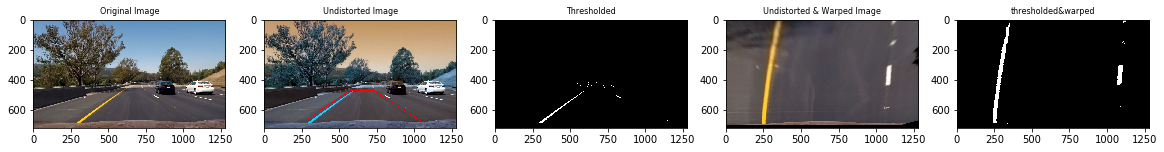

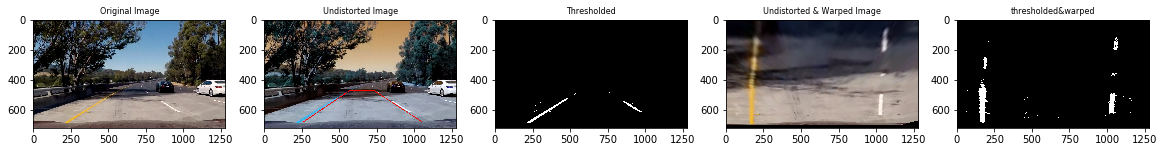

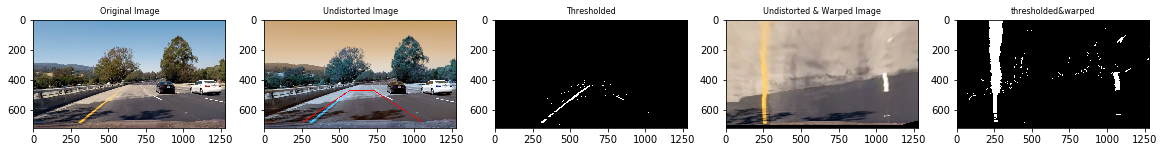

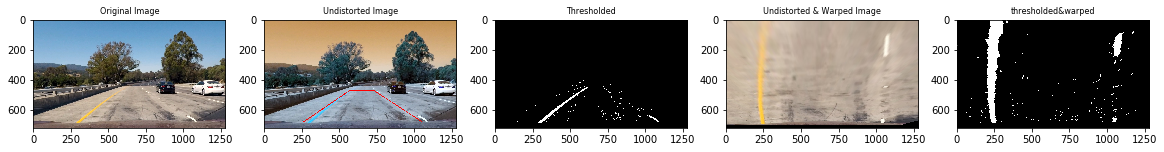

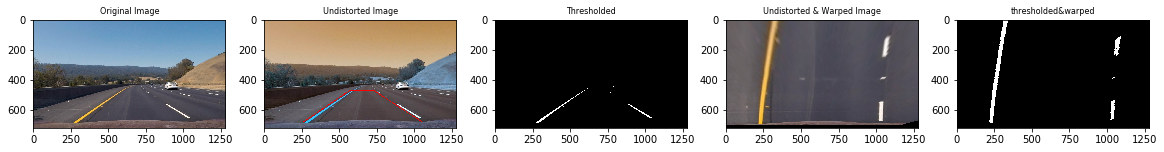

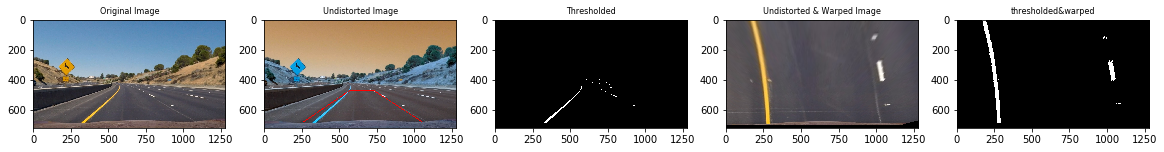

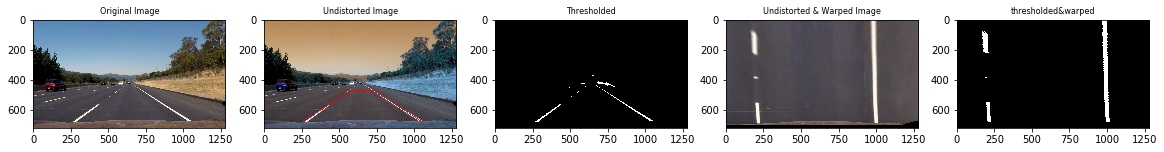

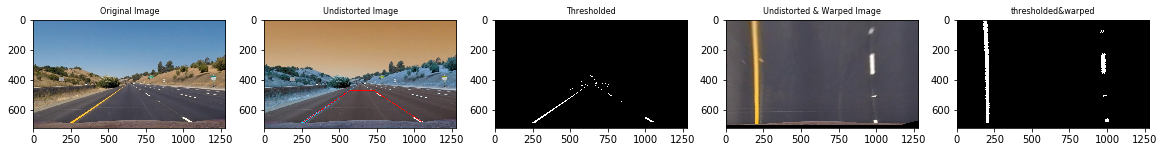

In [9]:
images_test = glob.glob('/Users/rickerish_nah/Documents/trials/udacity Q/test_images/*.jpg')
for i, img in enumerate(images_test):
    img = cv2.imread(img)#'/Users/rickerish_nah/Documents/trials/udacity Q/test_images/straight_lines1.jpg')
    test_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img_dst = undistort(test_img,mtx, dist)

    thresholded = get_thresholded_image(test_img)
    
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [260,680]
    bottom_right = [1050, 680]
    top_left = [570, 470]
    top_right = [725, 470]
    
    source = np.float32([bottom_left,bottom_right,top_right,top_left])
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    
    bottom_left = [200,680]
    bottom_right = [1000, 680]
    top_left = [200, 0]
    top_right = [1000, 0]
    
    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    img_size = (test_img.shape[1],test_img.shape[0])

    test_warp, M, Minv = transform(test_img_dst,source,dst,img_size)
    thresh_warp, M, Minv = transform(thresholded,source,dst,img_size)

    f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(20,30))
    ax1.imshow(test_img)
    ax1.set_title('Original Image', fontsize=8)
    ax2.imshow(copy)
    ax2.set_title('Undistorted Image', fontsize=8)
    ax3.imshow(thresholded,cmap = 'gray')
    ax3.set_title('Thresholded', fontsize=8)
    ax4.imshow(test_warp)
    ax4.set_title('Undistorted & Warped Image', fontsize=8)
    ax5.imshow(thresh_warp, cmap = 'gray')
    ax5.set_title('thresholded&warped', fontsize=8)

194 993


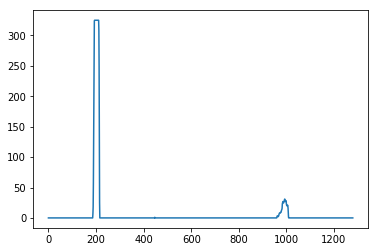

In [10]:
#Histogram to locate the lane line
def histogram(img_warped):
    hist = np.sum(img_warped[img_warped.shape[0]//2:,:], axis=0)
    # Peak in the first half indicates the likely position of the left lane
    half_width = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:half_width])
    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(hist[half_width:]) + half_width
    return hist, leftx_base, rightx_base


hist, leftx_base, rightx_base = histogram(thresh_warp)
print(leftx_base, rightx_base)
plt.plot(hist)

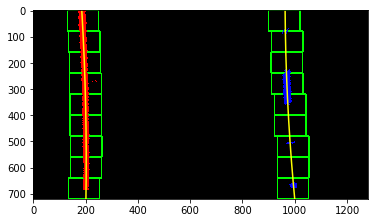

In [13]:
#Sliding Window Technique
def find_lane_pixels(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    bin_img=np.zeros_like(binary_warped)
    bin_img[lefty, leftx] = 255
    bin_img[righty, rightx] = 255
    
    return out_img, left_fit, right_fit, ploty


out_img, left_fit, right_fit, ploty = fit_polynomial(thresh_warp)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)


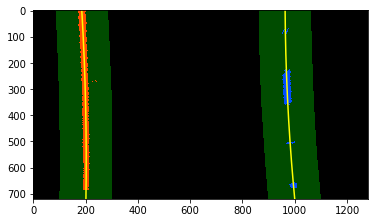

In [14]:
#Search from Prior
def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if len(leftx)==0:
        left_fit=[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if len(rightx)==0:
        right_fit=[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fit, right_fit, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
out_img_prior, left_fit_new, right_fit_new, ploty = search_around_poly(thresh_warp,left_fit, right_fit)
left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

# View your output
plt.plot(left_fitx, ploty, color='yellow')#_______________________
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img_prior)


In [15]:
#Measuring Radius of Curvature:
num_rows = test_warp.shape[0]
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

Radius of curvature: 2925.54 m


In [16]:
# compute the offset from the center
lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Center offset: 0.21 m


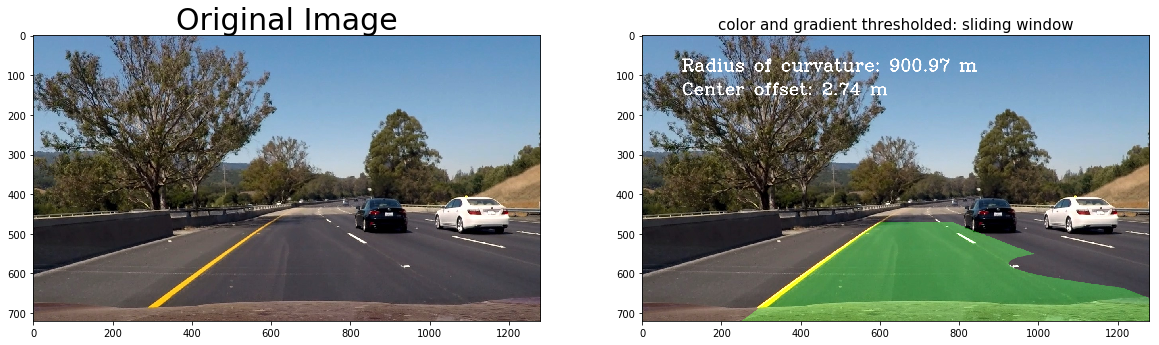

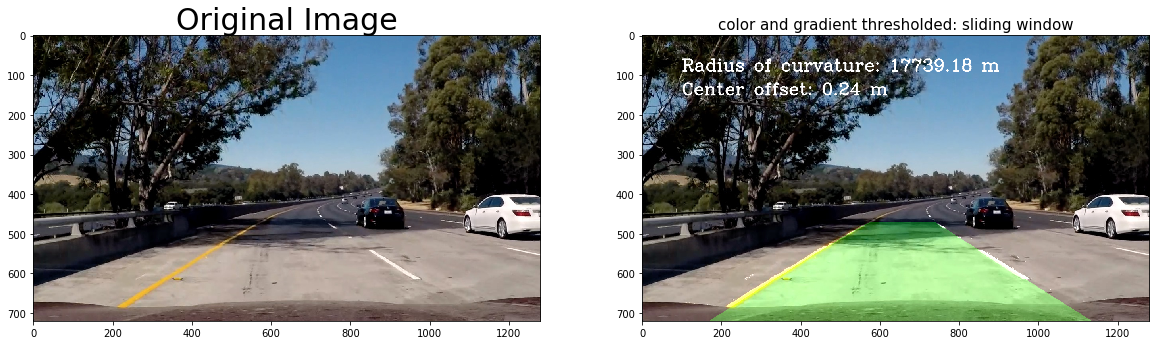

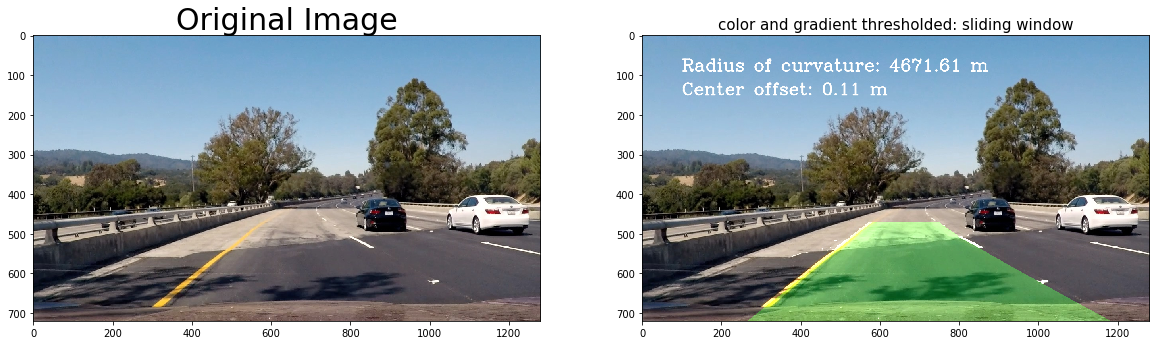

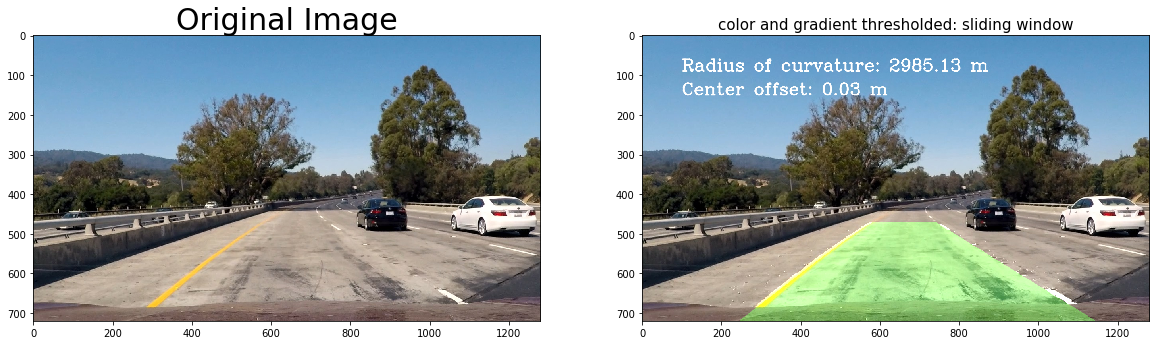

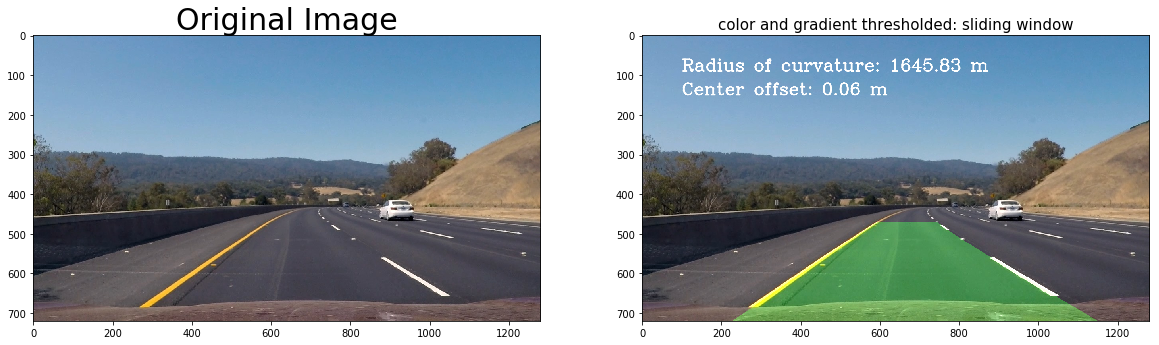

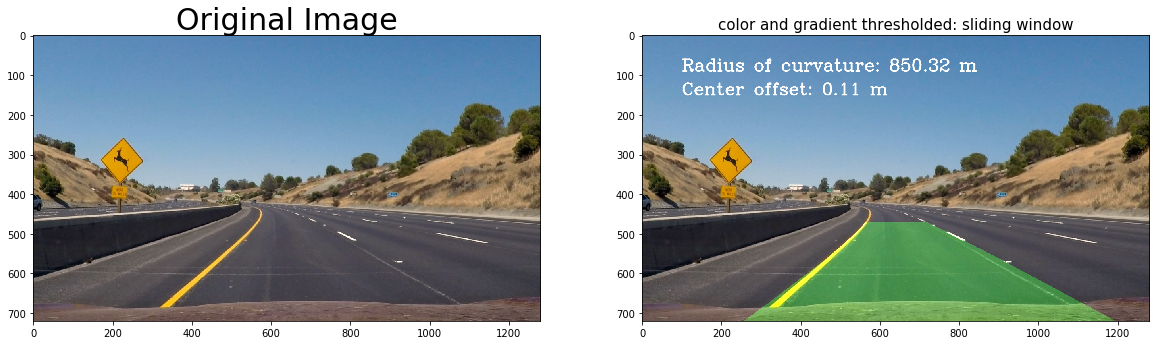

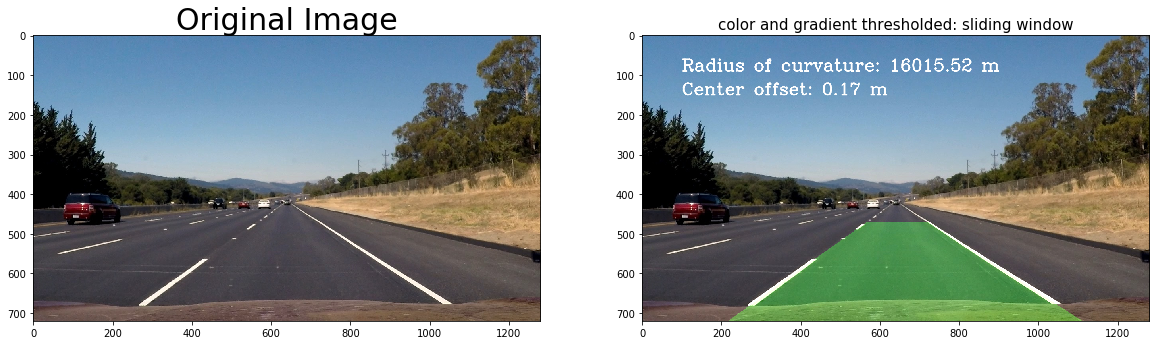

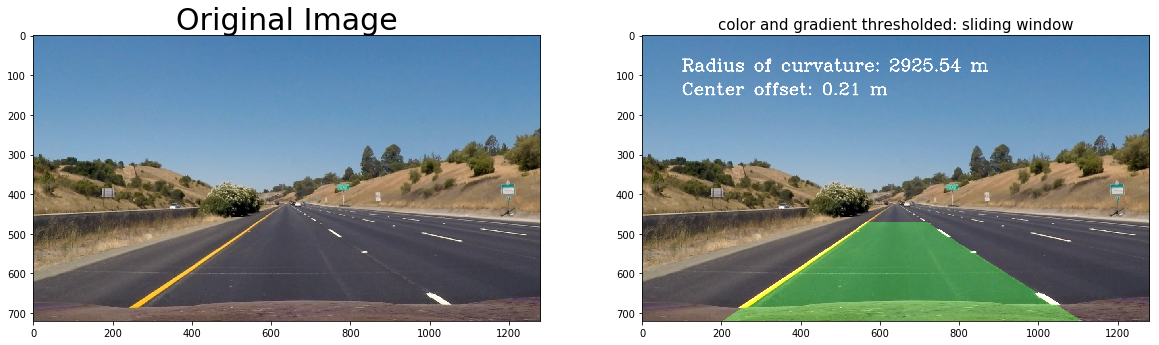

In [17]:
#Inverse Perspective Transform for sliding window
for i, img in enumerate(images_test):
    img = cv2.imread(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img = get_thresholded_image(img)
    img_size = (test_img.shape[1], test_img.shape[0])
    test_warp, M, Minv = transform(test_img,source,dst, img_size)
    
    out_img_prior, left_fit_new, right_fit_new, ploty = fit_polynomial(test_warp)#search_around_poly(test_warp,left_fit, right_fit)
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    #ROC
    left_curve_rad = measure_radius_of_curvature(left_fitx)
    right_curve_rad = measure_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    #Offset
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    
    out_img = np.dstack((test_warp, test_warp, test_warp))*255
    
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    result = cv2.putText(result,curvature_string,(100, 90), cv2.FONT_HERSHEY_COMPLEX, 1.4, (255,255,255),2,cv2.LINE_AA)
    result = cv2.putText(result,offset_string,(100, 150), cv2.FONT_HERSHEY_COMPLEX, 1.4, (255,255,255),2,cv2.LINE_AA)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(result)
    ax2.set_title('color and gradient thresholded: sliding window', fontsize=15)

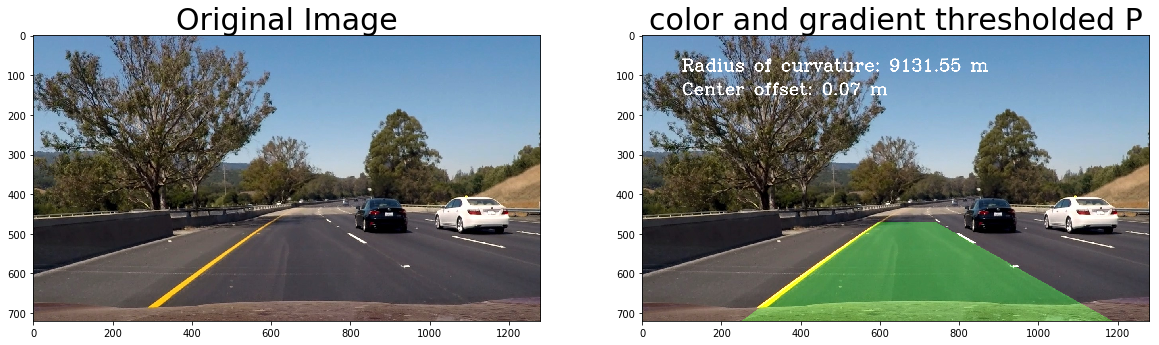

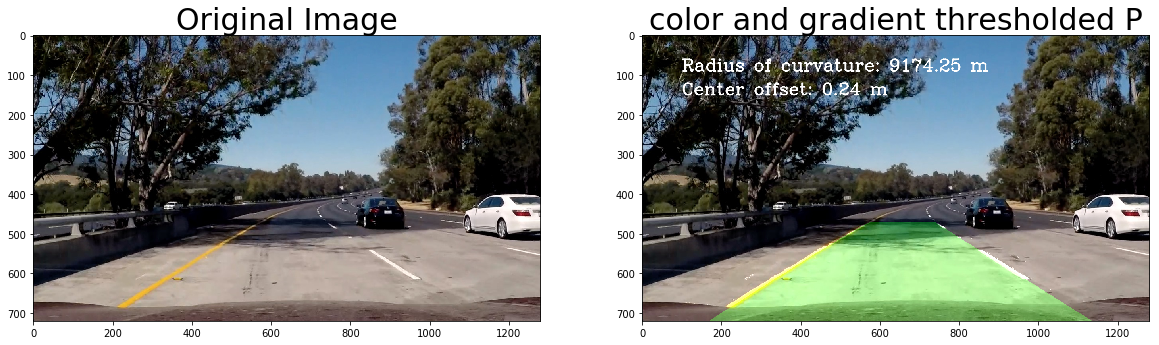

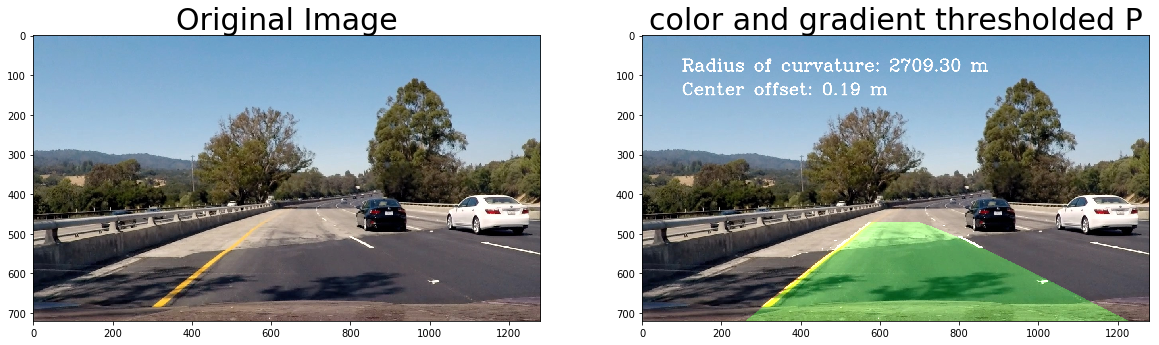

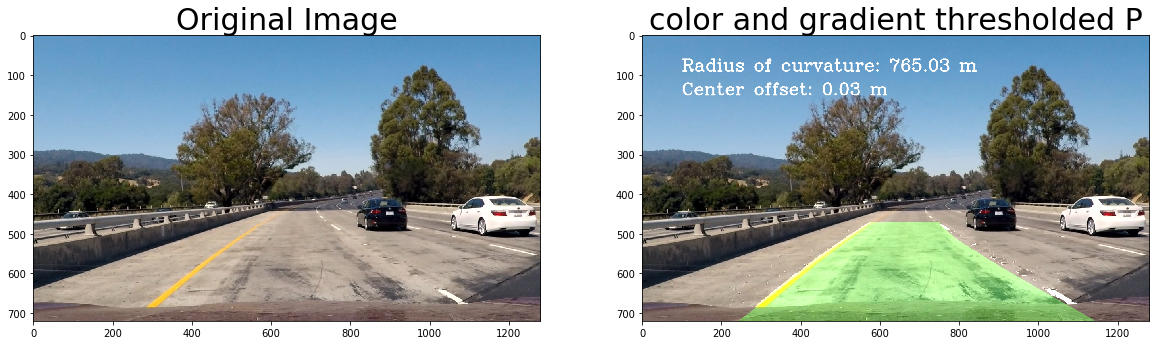

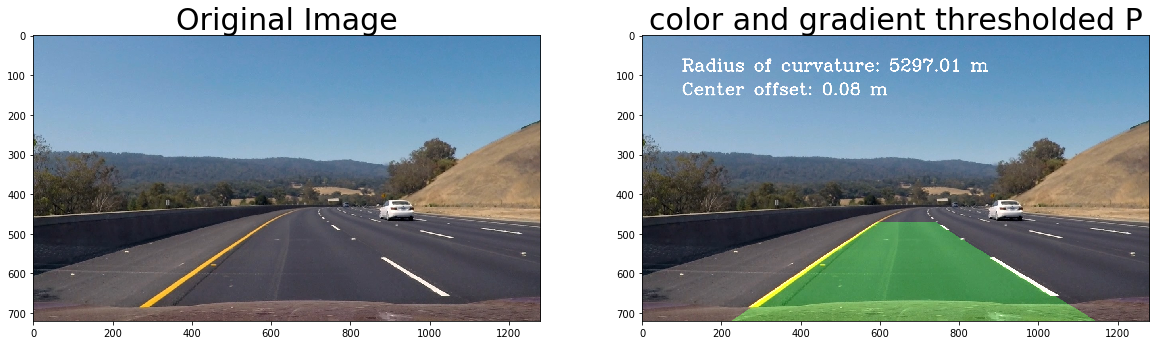

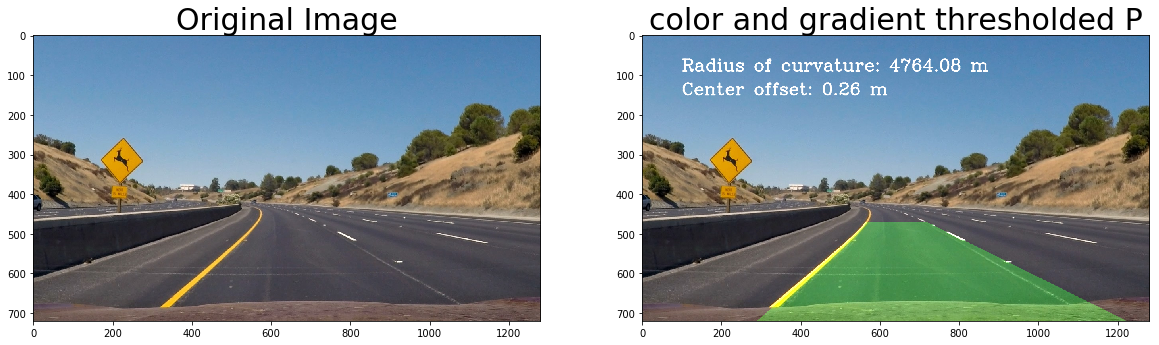

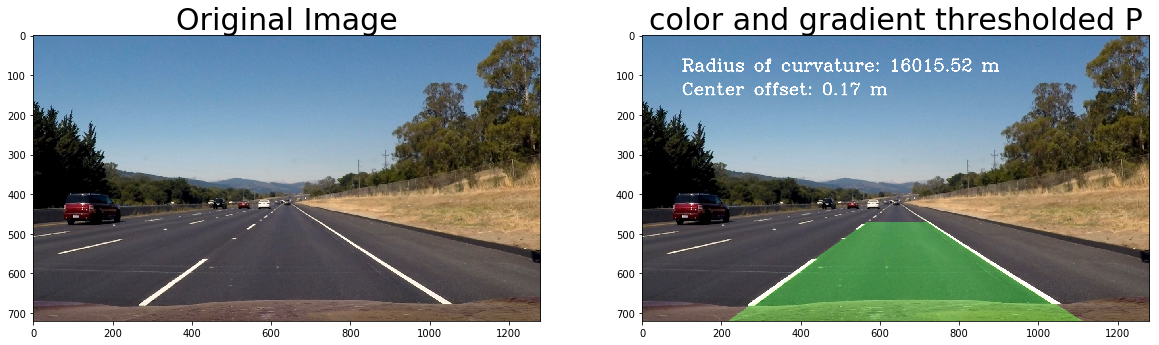

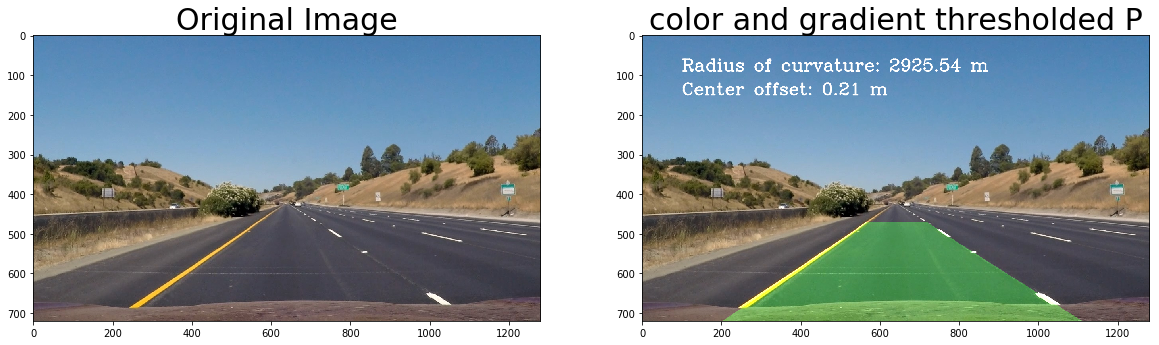

In [18]:
#Inverse Perspective Transform: Priori
for i, img in enumerate(images_test):
    img = cv2.imread(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img = get_thresholded_image(img)
    img_size = (test_img.shape[1], test_img.shape[0])
    test_warp, M, Minv = transform(test_img,source,dst, img_size)

    out_img_prior, left_fit_new, right_fit_new, ploty = search_around_poly(test_warp,left_fit, right_fit)
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    #ROC
    left_curve_rad = measure_radius_of_curvature(left_fitx)
    right_curve_rad = measure_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    #Offset
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs


    out_img = np.dstack((test_warp, test_warp, test_warp))*255

    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    result = cv2.putText(result,curvature_string,(100, 90), cv2.FONT_HERSHEY_COMPLEX, 1.4, (255,255,255),2,cv2.LINE_AA)
    result = cv2.putText(result,offset_string,(100, 150), cv2.FONT_HERSHEY_COMPLEX, 1.4, (255,255,255),2,cv2.LINE_AA)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(result)
    ax2.set_title('color and gradient thresholded P', fontsize=30)

In [19]:
print("PROJECT 4: Advanced Lane Finding........")

PROJECT 4: Advanced Lane Finding........


In [20]:
import numpy as np
import cv2, glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
%matplotlib inline

In [21]:
class Error(Exception):
    pass

In [22]:
#Camera Calibration
def camera_Calibraton(directory, filename, nx, ny, img_size):
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob.glob('/'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #print("name:",fname,"RET:",ret)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist

In [23]:
#Image undistort
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

In [24]:
#Perspective transform
def transform(undist,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M, Minv

In [25]:
def abs_sobel_thresh(image, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert(orient == 'x' or orient == 'y'), "Orientation must be x or y"
    
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
 
    return grad_binary

def mag_thresh(image, sobel_kernel, thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.power((np.power(sobelx,2)+np.power(sobely,2)),0.5)
    
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

In [26]:
def get_thresholded_image(img):
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(img, 'x', 3, thresh=(10, 200))
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(img, 3,thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,img.shape[0]-1], [img.shape[1]/2, int(0.5*img.shape[0])], [img.shape[1]-1, img.shape[0]-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

In [27]:

#Calibrating Camera
nx = 9
ny = 6
mtx, dist = camera_Calibraton('Users/rickerish_nah/Documents/trials/udacity Q/camera_cal', 'calibration', nx, ny, (720, 1280))

In [28]:
def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected 
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
               
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average

In [29]:
class Line_line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [30]:
# Video Processing Pipeline
def process_vid(image):
    
    img = undistort(image,mtx, dist)
    img_t=get_thresholded_image(img)
    img_size = (img_t.shape[1], img_t.shape[0])
    img_warp, M, Minv=transform(img_t, source, dst, img_size) 
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(img_warp)) 
    combined_binary = img_t.copy()
    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, img_warp)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, img_warp)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, source)
    
    warp_zero = np.zeros_like(img_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [31]:
Left=Line_line()
Right=Line_line()
white_output = "project_output.mp4"
clip1 = VideoFileClip('/Users/rickerish_nah/Documents/trials/udacity Q/project_video.mp4')
white_clip = clip1.fl_image(process_vid) #NOTE: this function expects color images!!

In [32]:
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [04:58<00:00,  4.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 4min 24s, sys: 46.9 s, total: 5min 11s
Wall time: 4min 59s


In [33]:
Left=Line_line()
Right=Line_line()
chall_output = "challenge_output.mp4"
clip1 = VideoFileClip('/Users/rickerish_nah/Documents/trials/udacity Q/challenge_video.mp4')
chall_clip = clip1.fl_image(process_vid) #NOTE: this function expects color images!!

In [34]:
%time chall_clip.write_videofile(chall_output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [01:25<00:00,  5.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 1min 17s, sys: 13.5 s, total: 1min 30s
Wall time: 1min 26s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chall_output))